In [1]:
from base_dataset import BaseDataset

from torchvision import transforms
import numpy as np
from PIL import Image
import cv2

/home/ubuntu/miniconda3/envs/hrnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# root_dir = '/home/ubuntu/data/workspace/deeplabv3_plus/people_segmentation'
# ds = BaseDataset(root_dir, img_dir="images", alpha_dir="masks")

In [3]:
# ds = BaseDataset( "/home/ubuntu/data/yong/projects/MODNet/data/PPM-100",
#         "image",
#         "matte")

100 samples


In [10]:
ds = BaseDataset( "/home/ubuntu/data/yong/dataset/Human-Segmentation-Dataset",
        "Training_Images",
        "Ground_Truth")

290 samples


In [17]:
sample = ds[20]

In [18]:
fn, img, trimap, alpha = sample

In [19]:
img.shape, trimap.shape, alpha.shape

(torch.Size([3, 512, 512]),
 torch.Size([1, 512, 512]),
 torch.Size([1, 512, 512]))

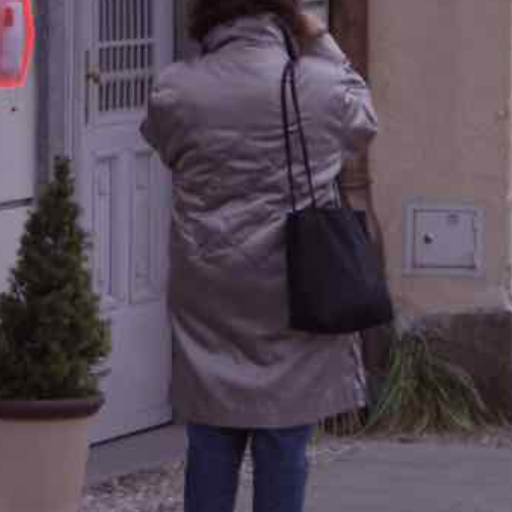

In [20]:
img_np = np.transpose(img, (1, 2, 0)).numpy()
img_np = (img_np * 0.5 + 0.5) * 255.0

Image.fromarray(np.array(img_np, dtype=np.uint8))

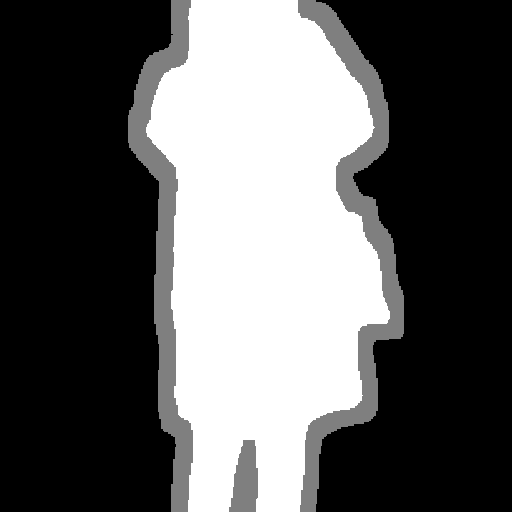

In [21]:
Image.fromarray(np.array(np.squeeze(np.transpose(trimap, (1, 2, 0))).numpy() * 255.0, dtype=np.uint8))

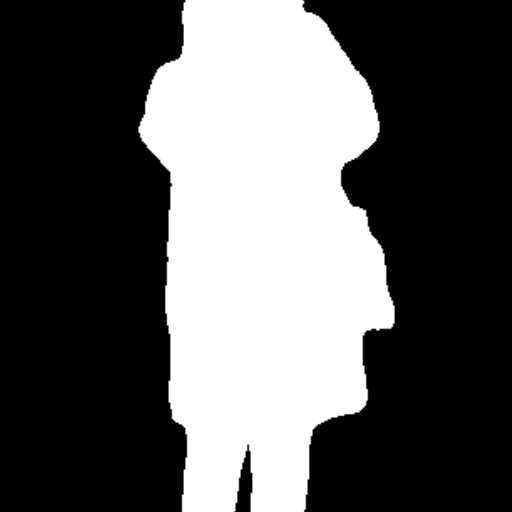

In [22]:
Image.fromarray(np.array(np.squeeze(np.transpose(alpha, (1, 2, 0))).numpy() * 255.0, dtype=np.uint8))